# Sales and traffic exercise 

**SUMMARY**
The data are explored for visual patterns and trends that might complicate the modeling results. There is an obvious daily and weekly pattern that introduces a high-frequency seasonality and on an annual basis a pick-up of sales and traffic between the Thanksgiving to New Year period. The data have a significant number of '0' values that represent closed periods of the shop. Dealing with these is tough and I have no good work-around but they clearly impact the model and provide a very poor model once seasonality has been adjusted. Some form of smoothing is required or use of a discrete model rather than a continuous time series model. Here I have modeled the data using SARIMAX and evaluated using the residuals and testing the model on previous data within the sales time period. The model is so inaccurate and needs significant tuning o I haven't provided a forecast - until the zero values are dealt with the model has very wide confidence intervals that make the result meaningless.

In [ ]:
# Expand dataframe with more useful columns
# def expand_df(df):
#     data = df.copy()
#     data['day'] = data.index.day
#     data['month'] = data.index.month
#     data['year'] = data.index.year
#     data['dayofweek'] = data.index.dayofweek
#     return data

# data = expand_df(train)
# display(data)

# grand_avg = data.sales.mean()
# print(f"The grand average of sales in this dataset is {grand_avg:.4f}")

In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller,grangercausalitytests
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime as dt

#Mute warning messages: If errors occur, hash-out this import
import warnings; warnings.simplefilter('ignore')

%matplotlib inline

In C:\Users\harri\.conda\envs\tsa_course\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\harri\.conda\envs\tsa_course\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\harri\.conda\envs\tsa_course\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
C:\Users\harri\.conda\envs\tsa_course\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


## Considerations and model rationale

The training exercise consists of 2 dataframes that are time-series. The first contains sales figures per hour in cents for a shop in the USA and the second dataframe contains traffic that represents people measured by sensors. There are missing data and the time series capture multiple holidays and other events. The aim is to predict the sales and traffic per hour for the next month. The type of shop is unknown. 

### Considerations

**Holidays**:- The USA has 10 Federal holidays that are observed by Federal government although in practice only 7 are usually observed in business and commerce. These are January 1st (New Year), Memorial Day (late May), Independence Day (July 4th), Labor Day (beginning September), Thanksgiving (third Thursday in November) and the next immediate Friday (not an official holiday), and finally Christmas Day in late December. In recent years, the USA has followed a trend similar to Europe in that the Christmas-New Year period has turned into a more protracted holiday period although technically the USA on observes Christmas Day. 

*Expectation* - depending on the type of store, you could expect an increase or decrease in traffic and sales during holiday periods. Holidays with an anticipated decrease in sales (Thanksgiving day itself, Christmas day) will have an increase in sales both before and after. They have complex lags and preceding events. They could look like 'humps' in the data with a dip on the holiday itself..


**Major sales**:- The USA also has Black Friday that falls just before Thanksgiving and is a time of massive sales across lots of different sectors in the same manner as New Year sales in the UK. Cyber Monday has also appeared in recent years although whether that impacts the shop in this training exercise is unknown.

*Expectations* - There could be a big increase in November in sales and also late December/early January. 

**Missing data**:- Missing values (0) could represent multiple causes that may or may not be primary to the data under review. They could represent no sales within the hour time period, they might represent a temporary closed period (if traffic is also 0), they could be a lag within the first one hour between people entering the shop just before the second hour time period within a trading day, or they could mean no data were recorded. Data exploration is needed to see any pattern that might help. Traffic values that score 0 could also have several underlying causes: They could be faulty sensors, sensors that broke-down for a period of time, sensors weren't installed for part of the time series, there is a lag between traffic and sales so a sale could occur in a time period without traffic (especially if it's at the end of a trading day), or no data were recorded. Faulty sensors might be indicated by random 0 entries throughout th time series, and broken or missing sensors might be represented by an extended series of time points that have 0 entries. If there is no traffic but a sale is recorded it could also indicate that the shop sales products outside of the store - for example online, by telephone or on a forecourt like a gas station.None of these examples would score as 'traffic' but would score as a sale. 

Ideally a continuous time series is needed so missing time periods need attention. When the shop is closed, these will score as '0' sales and traffic so there will be an artificial seasonality to the data -   the dataset will have several hours of data and then many hours of zeros. 

### Model rationale
Since these data represent a time series, OLS linear regression is not suitable since there will be a time component that introduces lag and is correlated with both the inputs and outputs. The issue of multicollinearity would come into play and if the two time series have different distributions or seasonalities that would deliver erroneous results. I'm expecting seasonality on a daily basis because I'm not excluding or smoothing the zero values. I've yet to find a good work-around for this issue since the expected output is hours not larger time domains (e.g. weeks) where data can be smoothed.  Since the exercise implies one model, the approach will be to use SARIMAX and to evaluate its performance in terms of normality of the residuals from the model.  

## Data exploration

In [2]:
''' 
Load dataframes and inspect shape
'''

sales = pd.read_csv('training_Sales.csv')
traffic = pd.read_csv('training_Traffic.csv')

print(sales.describe())
print('\n',traffic.describe())

              Value
count  67058.000000
mean     815.701631
std      100.306658
min        0.000000
25%      754.000000
50%      793.000000
75%      851.000000
max     6435.000000

               Value
count  58437.000000
mean       4.208755
std        4.059862
min        0.000000
25%        1.000000
50%        3.000000
75%        6.000000
max       39.000000


In [3]:
## They have different shapes: How many 0 values are in the dataframes:
print('Sales with 0 "Value" scores = ', (sales.Value == 0).sum())
print('Traffic with 0 "Value" scores = ', (traffic.Value == 0).sum())

## when does the time series start and what are the time increments?
print('\n Sales df start: \n',sales.head())
print('\n Traffic df start: \n',traffic.head())

## When does the time series end?
print('\n Sales df finish: \n',sales.tail(1))
print('\n Traffic df finish: \n',traffic.tail(1))

##How many null values are present?
print('\n Sales df null values: \n', sales['Value'].isna().sum())
print('\n Traffic df null values: \n', traffic['Value'].isna().sum())

Sales with 0 "Value" scores =  1
Traffic with 0 "Value" scores =  6169

 Sales df start: 
                   Date  Value
0  2013-11-07 13:00:00    830
1  2013-11-07 13:15:00    885
2  2013-11-07 13:30:00    938
3  2013-11-07 13:45:00    804
4  2013-11-07 14:00:00    793

 Traffic df start: 
                   Date  Value
0  2015-01-01 10:00:00      0
1  2015-01-01 10:15:00      1
2  2015-01-01 10:30:00      4
3  2015-01-01 10:45:00      3
4  2015-01-01 11:00:00      1

 Sales df finish: 
                       Date  Value
67057  2018-05-06 19:00:00    759

 Traffic df finish: 
                       Date  Value
58436  2018-05-06 21:00:00      1

 Sales df null values: 
 0

 Traffic df null values: 
 0


In [4]:
## Are the 0 values random for traffic or in a series of their own?
traffic.sort_values(by = ['Value'])[:10]

,Date,Value
0,2015-01-01 10:00:00,0
40566,2017-05-01 10:30:00,0
22810,2016-04-23 21:15:00,0
22809,2016-04-23 21:00:00,0
22766,2016-04-23 10:15:00,0
22765,2016-04-23 10:00:00,0
22764,2016-04-23 09:45:00,0
5232,2015-04-23 09:30:00,0
5231,2015-04-23 08:45:00,0
5230,2015-04-23 08:00:00,0


In [5]:
## What are the datatypes?

print(traffic.dtypes)
print('\n', sales.dtypes)

Date     object
Value     int64
dtype: object

 Date     object
Value     int64
dtype: object


In [3]:
## Move index and convert to datetime
sales.index = pd.to_datetime(sales.Date)
sales.head(20)

,Date,Value
Date,,
2013-11-07 13:00:00,2013-11-07 13:00:00,830
2013-11-07 13:15:00,2013-11-07 13:15:00,885
2013-11-07 13:30:00,2013-11-07 13:30:00,938
2013-11-07 13:45:00,2013-11-07 13:45:00,804
2013-11-07 14:00:00,2013-11-07 14:00:00,793
2013-11-07 14:30:00,2013-11-07 14:30:00,730
2013-11-07 14:45:00,2013-11-07 14:45:00,727
2013-11-07 16:00:00,2013-11-07 16:00:00,729
2013-11-07 18:00:00,2013-11-07 18:00:00,889


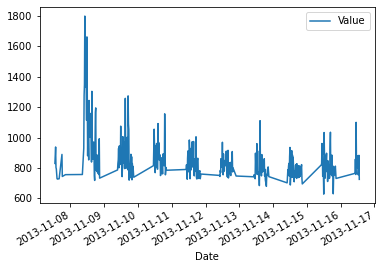

In [7]:
## What are the likely business hours?
# sales.iloc[:500].to_csv('sales_cut.csv') #visually inspect

sales.iloc[:350].plot();

## The time series starts on a Friday just before Veterans Day for 2013.

In [9]:
## When are the outlier periods in the sales?
sales.sort_values(by = ['Value'], ascending=False)[:10]

# The scale doesn't help, but it looks like there are peak sales that might be connected with 
# Independence Day celebrations (or just after) and also the Labor Day holidays. The fourth highest sales
# figure may relate to Martin Luther King Day.  There is no obvious pattern although December seems to 
# have generally higher sales figures.

,Date,Value
Date,,
2017-07-09 19:15:00,2017-07-09 19:15:00,6435
2015-08-29 14:00:00,2015-08-29 14:00:00,3027
2015-04-11 14:15:00,2015-04-11 14:15:00,2987
2016-01-23 14:15:00,2016-01-23 14:15:00,2740
2016-12-31 17:00:00,2016-12-31 17:00:00,2144
2017-06-19 15:30:00,2017-06-19 15:30:00,2075
2017-06-19 15:45:00,2017-06-19 15:45:00,1950
2016-12-09 22:45:00,2016-12-09 22:45:00,1860
2015-12-19 13:00:00,2015-12-19 13:00:00,1832


## EDA initial comments for sales data

* The size of the dataframes is different and the sales figures have a longer time series. Sales start in 2013 while traffic has values from 2015.
* There are sales figures when there are no traffic figures. There must be a lag and/or different ways of registering a sale such as online.
* Time periods are in 15 minute increments that will need grouping into hour increments.
* There are no null values, just 0 and integers.
* The sales clearly have some sort of business hour that in the week is about 10am to 10pm but this varies by day of the week. 
* The dataframes are not in datetime format but both will need converting and dates should go into the index for easier filtering
* While the traffic data also records night-time values, sales are only recorded when there are sales except for one 0 value.

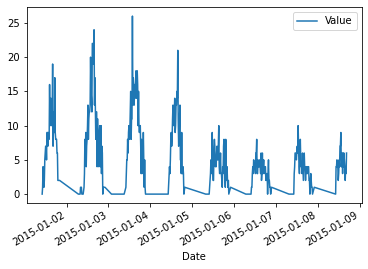

In [4]:
## Inspect traffic data. This should be similar to sales

traffic.index = pd.to_datetime(traffic.Date)
traffic.iloc[:350].plot()
plt.show()


## The traffic figures appear to have cyclicity based on visual inspection. 

### Convert to hours and merge

In [5]:
'''
Convert to sales df to hours. pd.Grouper only works if you convert the datetime as per the previous steps. In this case sales are in business hours and thse 
vary throughout the week. By default these are M-F only but here the sales are 7 days a week. Here they are just set to H for hour.
'''

sales_hr = sales.groupby(pd.Grouper(freq='H')).sum()
traffic_hr = traffic.groupby(pd.Grouper(freq='H')).sum()

In [12]:
## Do a larger view so you can see how many hours the shop is open (e.g. 40). It's from 10am to 10pm
# sales_hr.head(12) 
traffic_hr.head(12)

,Value
Date,
2015-01-01 10:00:00,8
2015-01-01 11:00:00,14
2015-01-01 12:00:00,28
2015-01-01 13:00:00,33
2015-01-01 14:00:00,47
2015-01-01 15:00:00,49
2015-01-01 16:00:00,48
2015-01-01 17:00:00,43
2015-01-01 18:00:00,28


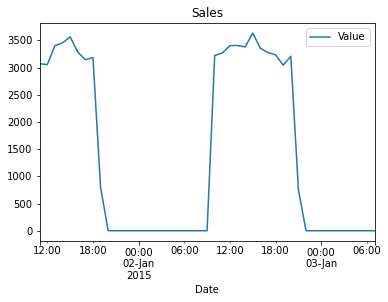

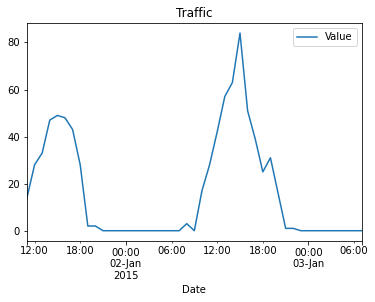

In [6]:
sales_hr['2015-1-1 11:00:00':' 2015-1-3 07:00:00'].plot(title='Sales');

traffic_hr['2015-1-1 11:00:00':' 2015-1-3 07:00:00'].plot(title='Traffic');

Since the 'Value' dataset contains more than 12 months of observations than the 'Traffic' dataset, it is easiest to merge the data and drop the observations that are not common to both dataframes. The forecast period ahead means that this data is excess to requirements in any case. Also the df needs to accommodate future exogenous events (i.e. holidays) so needs an additional 1 month of rows appending to the tail.

In [7]:
'''
Merge sales on traffic (it's possible to get traffic without a sale but unlikely the other way around unless sales can be online). 
'''
sales_traffic_hr  = pd.merge(traffic_hr, sales_hr, on='Date')

## Check the columns
sales_traffic_hr.columns

## Rename the columns
sales_traffic_hr = sales_traffic_hr.rename(columns={'Value_x': 'Traffic', 'Value_y': 'Sales'})

In [10]:
sales_traffic_hr.tail()
# sales_traffic_hr.shape

,Traffic,Sales
Date,,
2018-05-06 15:00:00,41,3645
2018-05-06 16:00:00,33,3372
2018-05-06 17:00:00,27,3077
2018-05-06 18:00:00,14,3190
2018-05-06 19:00:00,4,759


In [11]:
## Get new dates 1 month ahead of current df and append to the sales adn traffic data.

#1 month ahead
holiday_dates = pd.date_range(start='2018-05-06 20:00:00', end='2018-06-06 20:00:00', freq='H')
print(len(holiday_dates))
print(len(sales_traffic_hr))

745
29314


In [12]:
#Check length of desired new df
print('\nNew df len:\n',745 + 29314)


New df len:
 30059


In [13]:
#Get a new index 
new_ix = sales_traffic_hr.index.append(holiday_dates)
len(new_ix)

30059

In [14]:
##Make a dummy dataframe for the holiday column
hol_df = pd.DataFrame(index=holiday_dates, columns=['Holidays'])
hol_df.index.name = 'Date'
hol_df['Holidays'] = 0 #Leaving as NaN will not allow for concat or merge so fill with a placeholder val.
hol_df.head()

,Holidays
Date,
2018-05-06 20:00:00,0
2018-05-06 21:00:00,0
2018-05-06 22:00:00,0
2018-05-06 23:00:00,0
2018-05-07 00:00:00,0


In [15]:
dummy_df = pd.concat([sales_traffic_hr, hol_df])
dummy_df.tail()

,Traffic,Sales,Holidays
Date,,,
2018-06-06 16:00:00,NaN,NaN,0.0
2018-06-06 17:00:00,NaN,NaN,0.0
2018-06-06 18:00:00,NaN,NaN,0.0
2018-06-06 19:00:00,NaN,NaN,0.0
2018-06-06 20:00:00,NaN,NaN,0.0


In [16]:
##Check there are no duplicates date stamps (there shouldn't be)
dups = dummy_df.index.duplicated().astype('str')

d = []

for dup in dups:
    if str(True) in dup:
        d.append(dup)
d

[]

In [17]:
len(dummy_df)

30059

In [18]:
## Get the days of the week and use saturday and sunday as exogenous variables
dummy_df['Weekday'] = dummy_df.index.weekday 

# Monday is 0, Sunday is 6. Make a placeholder list to serahc over for weekends.
wk = [5,6] #Saturday and Sunday
dummy_df['Weekends'] =np.where(dummy_df['Weekday'].isin(wk), 1,0)
# dummy_df.head(50)

,Traffic,Sales,Holidays,Weekday
Date,,,,
2015-01-01 10:00:00,8.0,2057.0,NaN,3
2015-01-01 11:00:00,14.0,3071.0,NaN,3
2015-01-01 12:00:00,28.0,3054.0,NaN,3
2015-01-01 13:00:00,33.0,3403.0,NaN,3
2015-01-01 14:00:00,47.0,3453.0,NaN,3


In [19]:
wk = [5,6] #Saturday and Sunday
dummy_df['Weekends'] =np.where(dummy_df['Weekday'].isin(wk), 1,0)
# dummy_df.head(50)

,Traffic,Sales,Holidays,Weekday,Weekends
Date,,,,,
2015-01-01 10:00:00,8.0,2057.0,NaN,3,0
2015-01-01 11:00:00,14.0,3071.0,NaN,3,0
2015-01-01 12:00:00,28.0,3054.0,NaN,3,0
2015-01-01 13:00:00,33.0,3403.0,NaN,3,0
2015-01-01 14:00:00,47.0,3453.0,NaN,3,0
2015-01-01 15:00:00,49.0,3564.0,NaN,3,0
2015-01-01 16:00:00,48.0,3285.0,NaN,3,0
2015-01-01 17:00:00,43.0,3143.0,NaN,3,0
2015-01-01 18:00:00,28.0,3183.0,NaN,3,0


## Insert US Federal holidays into DF

There is no information on the US state so only Federal holidays will be used in the dataframe from 2015-01-01 until 2018-05-06.


In [77]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
holidays = cal.holidays(start='2014-12-30', end='2018-06-07') #Make sure holidays capture NY and also extend a month beyond the df

In [78]:
holidays

DatetimeIndex(['2015-01-01', '2015-01-19', '2015-02-16', '2015-05-25',
               '2015-07-03', '2015-09-07', '2015-10-12', '2015-11-11',
               '2015-11-26', '2015-12-25', '2016-01-01', '2016-01-18',
               '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05',
               '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-26',
               '2017-01-02', '2017-01-16', '2017-02-20', '2017-05-29',
               '2017-07-04', '2017-09-04', '2017-10-09', '2017-11-10',
               '2017-11-23', '2017-12-25', '2018-01-01', '2018-01-15',
               '2018-02-19', '2018-05-28'],
              dtype='datetime64[ns]', freq=None)

In [79]:
## Split dates into just days so that the holidays can map onto all the relevant hours of the day rather than just 00:00:00 in the first hour of a given holiday.
day = dummy_df.index.map(lambda x: x.strftime('%Y-%m-%d')) #Note - this is a string and needs converting to dt object.

dummy_df['Day'] = pd.to_datetime(day) #this is a dt object and in a seperate column
dummy_df['Holidays'] =np.where(dummy_df['Day'].isin(holidays), 1,0) #first val if true
dummy_df.drop('Day', axis=1, inplace=True)
dummy_df.tail()

,Traffic,Sales,Holidays
Date,,,
2018-06-06 16:00:00,NaN,NaN,0
2018-06-06 17:00:00,NaN,NaN,0
2018-06-06 18:00:00,NaN,NaN,0
2018-06-06 19:00:00,NaN,NaN,0
2018-06-06 20:00:00,NaN,NaN,0


Some take home points:-

**Outliers** 
Should these be removed? They may be correlated with lower sales later in the same month assuming that loyal customers are making these purchases. Will the really screw-up the model?

**Different time series durations**
This is a problem if both traffic and sales are part of the same model. They need to match. So cut the df so that only matching hour data are present. This cuts out c. 2 years of sales data. In addition this is a large amount of data so for expediency the dataframe may need to be cut to a smaller time window just to run on my computer. 

There are lots of zeros in the dataset - when the data are grouped into hours, it's obvious that many of these are when the shop is shut (after 8pm, before 8am). Question - should these be culled? Or since the same values will be present in the forecast month ahead, then they form part of the pattern and should stay? Not sure...so keep them in to start with, and then remove all rows with sales == 0 and traffic == 0. A continuous series is needed so I'm keeping them for parsimony here until I can figure a suitable alternative! (Needs more personal researching)


## Model

Before fitting ARIMA type models, the data need exploring to see stationarity and causality between variables. There are different ways to get a stationary series - fit many models iteratively and then select the one with the lowest log-likelihood (GridSearch) or use an autocorrelation and partial autocorrelation plot and then check with a Dickey Fuller test.

In this instance, the next month is forecast and evaluated for both sales and traffic. In order to train a model and test it, a year is used so the dataframe requires cutting back.

In [84]:
cut_df_extended = dummy_df.loc['2017-11-01 01:00:00':'2018-06-06 20:00:00']
print(cut_df_extended.shape)
# cut_df.extended.to_csv('cut_df.csv')

(5228, 3)


In [85]:
## Make a copy and drop NaNs from extended series
cut_df = cut_df_extended.dropna()
cut_df.tail()

,Traffic,Sales,Holidays
Date,,,
2018-05-06 15:00:00,41.0,3645.0,0
2018-05-06 16:00:00,33.0,3372.0,0
2018-05-06 17:00:00,27.0,3077.0,0
2018-05-06 18:00:00,14.0,3190.0,0
2018-05-06 19:00:00,4.0,759.0,0


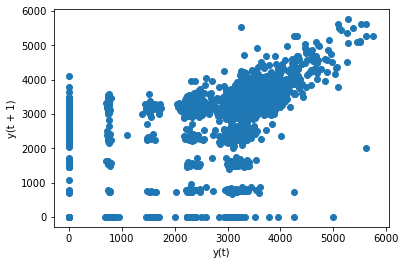

In [86]:
## Autocorrelation looking at lags in the sales data
from pandas.plotting import lag_plot

lag_plot(cut_df['Sales']);

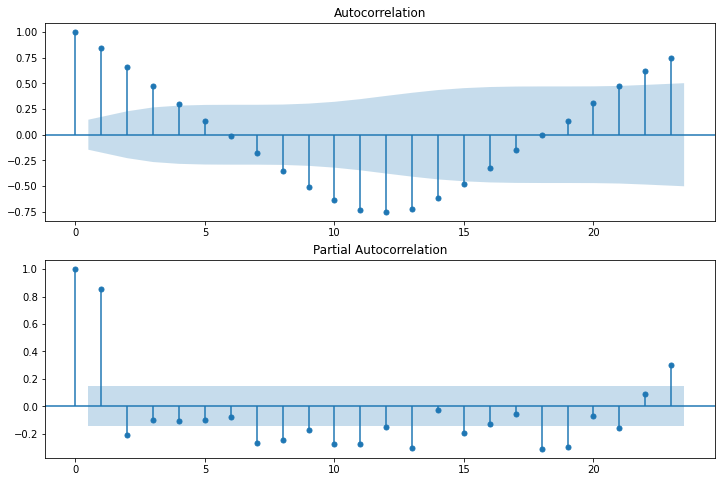

In [87]:
## Autocorrelation
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(cut_df['Sales'][:180], ax=ax1)

#Partial autocorrelation (works best on stationary - differenced - data but here ACF shows the pattern already)
ax2 = fig.add_subplot(212)
fig = plot_pacf(cut_df['Sales'] [:180], ax=ax2)
plt.show()


## This implies seasonality - daily patterns as expected on 24hr timeperiods.

## Stationarity of the sales data

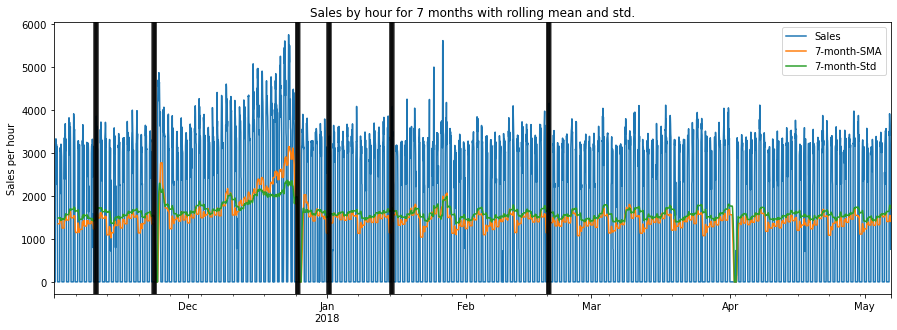

In [88]:
##Plot sales and rolling mean and std. Overlay holidays as bars.

title='Sales by hour for 7 months with rolling mean and std.'
ylabel='Sales per hour'
xlabel='' 

cut_df['7-month-SMA'] = cut_df['Sales'].rolling(window=25).mean()
cut_df['7-month-Std'] = cut_df['Sales'].rolling(window=25).std()

ax = cut_df[['Sales','7-month-SMA','7-month-Std']].plot(figsize=(15,5), title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in cut_df.query('Holidays==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);  
    
## Shows a clear pick up around Thanksgiving to Christmas-New Year as well as Independence Day although that is lagged here. 

In [89]:
## Apply an Adjusted Dickey-Fuller test to help establish if data are stationary.

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [90]:
adf_test(cut_df['Sales'], 'ADF test for stationarity, sales')

## The strong negative value and the very small p value mean the null hypothesis is rejected (i.e. that the data are not stationary) since it is smaller 
## than the critical values - it does not have a unit root and implies a stationary time-series although the diagram 
## of PCF and ACF plus the decomposition imply differently. Presumably the data have a cyclostationary pattern on a daily cycle.

Augmented Dickey-Fuller Test: ADF test for stationarity, sales
ADF test statistic     -9.929561e+00
p-value                 2.846742e-17
# lags used             3.200000e+01
# observations          4.450000e+03
critical value (1%)    -3.431820e+00
critical value (5%)    -2.862190e+00
critical value (10%)   -2.567116e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


## Are sales and value causal and/or correlative?

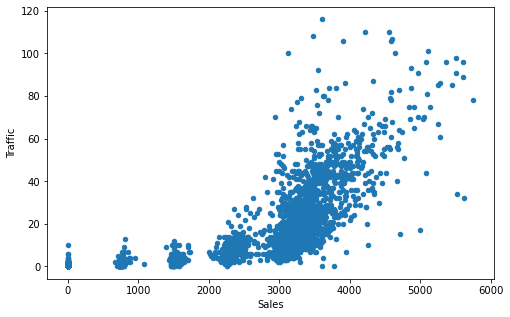

In [91]:
##Plot sales vs. traffic. Should expect some strong relationship:

cut_df.plot.scatter(x='Sales', y='Traffic',figsize=(8,5));

## Data appear binned - maybe this is an artefact of how the original data were synthetically generated.

In [92]:
grangercausalitytests(cut_df[['Sales','Traffic']],maxlag=2);

##My interpretation here is that there is minimal or no lag between traffic and sales - essentially people do not spend more than one hour in the shop
##and the traffic and sales capture both events within the 1 hour time period. They are synchronous in this binned hourly data.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=70.2717 , p=0.0000  , df_denom=4479, df_num=1
ssr based chi2 test:   chi2=70.3187 , p=0.0000  , df=1
likelihood ratio test: chi2=69.7728 , p=0.0000  , df=1
parameter F test:         F=70.2717 , p=0.0000  , df_denom=4479, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=120.7494, p=0.0000  , df_denom=4476, df_num=2
ssr based chi2 test:   chi2=241.7686, p=0.0000  , df=2
likelihood ratio test: chi2=235.4719, p=0.0000  , df=2
parameter F test:         F=120.7494, p=0.0000  , df_denom=4476, df_num=2


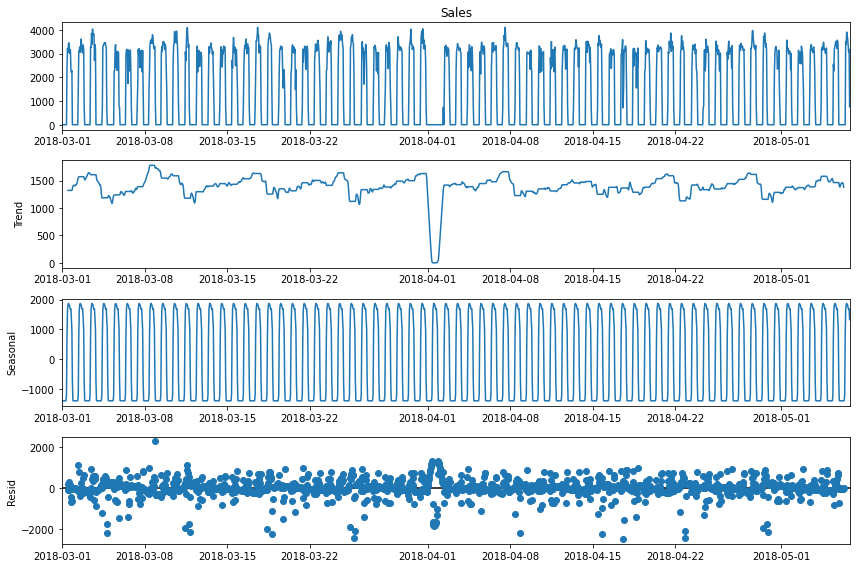

In [93]:
'''
Check time-series with decomposition that splits input into trend, seasonality and noise components. Cut to last 3 months in order to see the patterns 
of seasonality and the trend that are obscured by plotting constraints in the full data.
'''
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

decomposition = sm.tsa.seasonal_decompose(cut_df.Sales['2018-03-01 00:00:00':], model='additive')
fig = decomposition.plot()
plt.show()

## These are complex with a trend on a weekly cycle and and also seasonality on a daily cycle.

There is a seasonal trend in the days and in the weeks implying greater sales towards the end of a week. This is match by traffic with is intuitive.

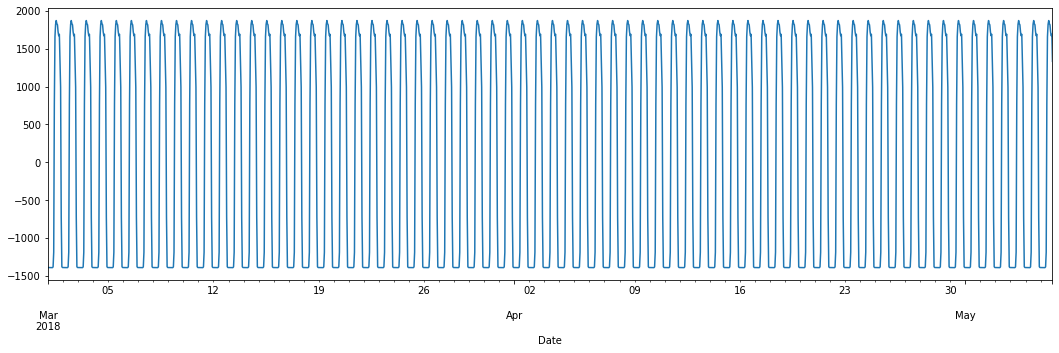

In [94]:
decomposition.seasonal.plot(figsize=(18,5));

## How do the traffic data compare to sales? 

Presumably, these will be very similar with seasonality and a stationary trend overall.

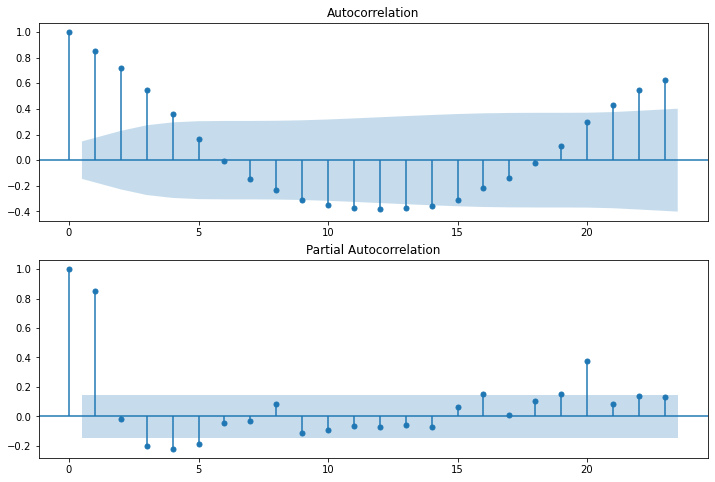

In [95]:
## Check the traffic data to see how this compares. Expect almost similar general patterns to the sales data

## Autocorrelation
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(cut_df['Traffic'][:180], ax=ax1)

#Partial autocorrelation (works best on stationary - differenced - data but here ACF shows the pattern already)
ax2 = fig.add_subplot(212)
fig = plot_pacf(cut_df['Traffic'] [:180], ax=ax2)
plt.show()

In [96]:
adf_test(cut_df['Traffic'], 'ADF test for stationarity, traffic')

## As expected, traffic data are stationary.

Augmented Dickey-Fuller Test: ADF test for stationarity, traffic
ADF test statistic     -7.203747e+00
p-value                 2.329056e-10
# lags used             2.700000e+01
# observations          4.455000e+03
critical value (1%)    -3.431819e+00
critical value (5%)    -2.862189e+00
critical value (10%)   -2.567115e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


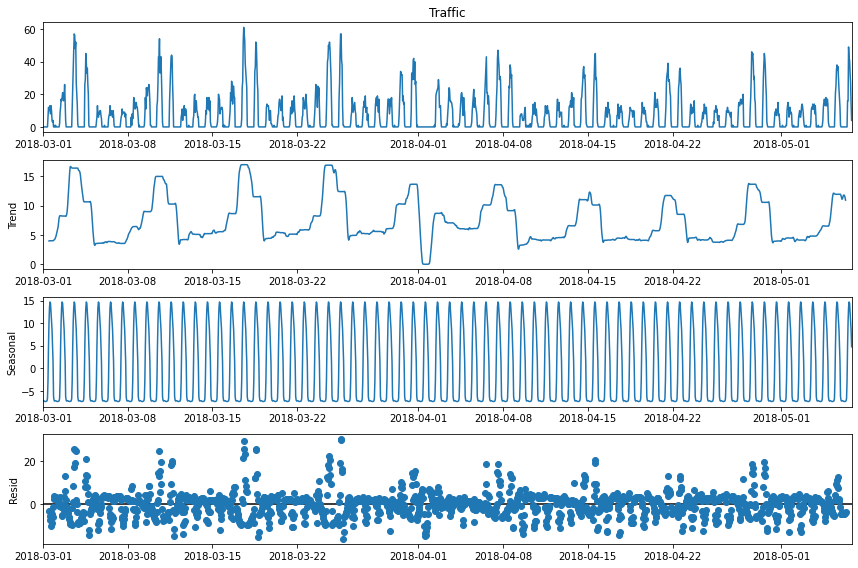

In [97]:
'''
Check traffic time-series with decomposition that splits input into trend, seasonality and noise components. Cut to last 3 months in order to see the patterns 
of seasonality and the trend that are obscured by plotting constraints in the full data.
'''
rcParams['figure.figsize'] = 12, 8

decomposition = sm.tsa.seasonal_decompose(cut_df.Traffic['2018-03-01 00:00:00':], model='additive')
fig = decomposition.plot()
plt.show()

## These are complex with a trend on a weekly cycle with more people on weekends and and also seasonality on a daily cycle.

# SARIMAX on sales data

Since the data have an exogenous variable (holidays), this can be treated as exogenous and used against either Sales or Traffic.

In [129]:
# cut_df = pd.read_csv('cut_df.csv', index_col='Date')
cut_df.head()

,Traffic,Sales,Holidays
Date,,,
2017-11-01 01:00:00,0.0,0.0,0
2017-11-01 02:00:00,0.0,0.0,0
2017-11-01 03:00:00,0.0,0.0,0
2017-11-01 04:00:00,0.0,0.0,0
2017-11-01 05:00:00,0.0,0.0,0


In [5]:
# For SARIMAX, set seasonal=True. Here m=24 since the seasonals are in 24 hour cycles. 
auto_arima(cut_df['Sales'], exogenous = cut_df[['Holidays']], seasonal=True,m=24).summary()

# stepwise_fit = auto_arima(cut_df['Sales'], exogenous = cut_df[['Holidays']],
#                           start_p=1, start_q=1,
#                           max_p=5, max_q=3, m=24,
#                           start_P=0, seasonal=True,
#                           d=None, D=1, trace=True,
#                           error_action='ignore',   # we don't want to know if an order does not work
#                           suppress_warnings=True,  # we don't want convergence warnings
#                           stepwise=True)           # set to stepwise

# stepwise_fit.summary()

##Best model:  ARIMA(2,0,2)(1,1,1)[7] intercept
##Total fit time: 1400.894 seconds

##Best model without exogenous is  SARIMAX(1, 0, 0)x(2, 0, [1], 24)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                 4483
Model:             SARIMAX(1, 0, 0)x(2, 0, [1], 24)   Log Likelihood              -34567.319
Date:                              Sun, 20 Dec 2020   AIC                          69146.637
Time:                                      20:08:09   BIC                          69185.085
Sample:                                           0   HQIC                         69160.187
                                             - 4483                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     16.0946      2.339      6.880      0.000      11.509      20.680
ar.L1          0.6075      0.006    110.409      0.000       0.597       0.618
ar.S.L24       0.7963      0.011     70.213      0.000       0.774       0.819
ar.S.L48       0.1710      0.010     16.336      0.000       0.150       0.192
ma.S.L24      -0.7481      0.009    -86.913      0.000      -0.765      -0.731
sigma2      2.414e+05   2221.140    108.660      0.000    2.37e+05    2.46e+05
===================================================================================
Ljung-Box (L1) (Q):                  15.74   Jarque-Bera (JB):              7662.97
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [6]:
## Calculate start and end points of df to get length of test data.
len(cut_df)
print(cut_df.iloc[:1])
print(cut_df.iloc[-1:])

                     Sales  Traffic  Holidays
Date                                         
2017-11-01 01:00:00      0        0         0
                     Sales  Traffic  Holidays
Date                                         
2018-05-06 19:00:00    759        4         0


In [7]:
## Split data into a test and training set. Test using 1 month
train = cut_df[:'2018-04-01 00:00:00']
test = cut_df['2018-04-01 01:00:00':]

In [8]:
model = SARIMAX(train['Sales'], exogenous=[['Holidays']],order=(1,0,0),seasonal_order=(2,0,1,24),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Sales   No. Observations:                 3624
Model:             SARIMAX(1, 0, 0)x(2, 0, [1], 24)   Log Likelihood              -28347.605
Date:                              Sun, 20 Dec 2020   AIC                          56705.209
Time:                                      20:12:19   BIC                          56736.186
Sample:                                  11-01-2017   HQIC                         56716.245
                                       - 04-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5876      0.015     39.467      0.000       0.558       0.617
ar.S.L24       1.1465      0.021     54.147      0.000       1.105       1.188
ar.S.L48      -0.1466      0.021     -6.938      0.000      -0.188      -0.105
ma.S.L24      -0.9740      0.007   -130.813      0.000      -0.989      -0.959
sigma2       6.18e+05    1.7e-09   3.64e+14      0.000    6.18e+05    6.18e+05
===================================================================================
Ljung-Box (L1) (Q):                  13.44   Jarque-Bera (JB):              9000.70
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.91e+29. Standard errors may be unstable.
"""

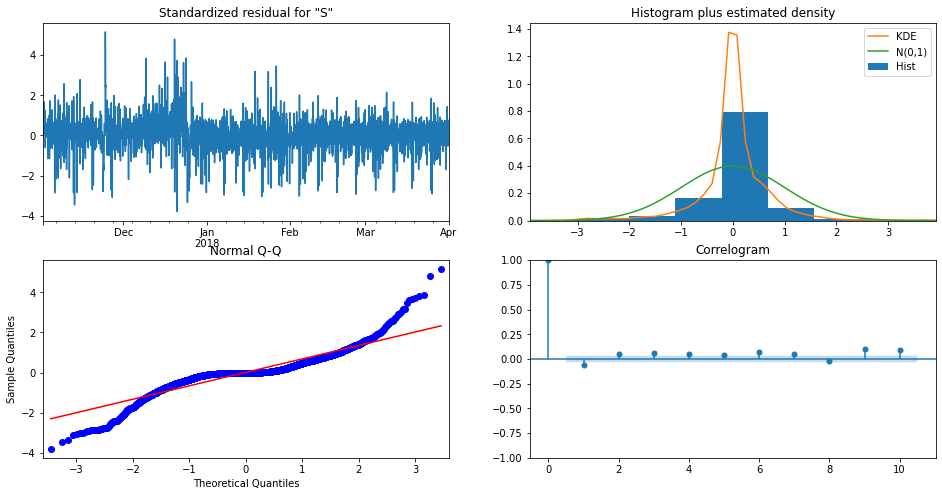

In [9]:
## Run diagnostics to see how the model behaves
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## The QQ plot shows that this doesn't divert from normality. 

In [10]:
## Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False).rename('SARIMAX(1,0,0)(2,0,1,24) Predictions')

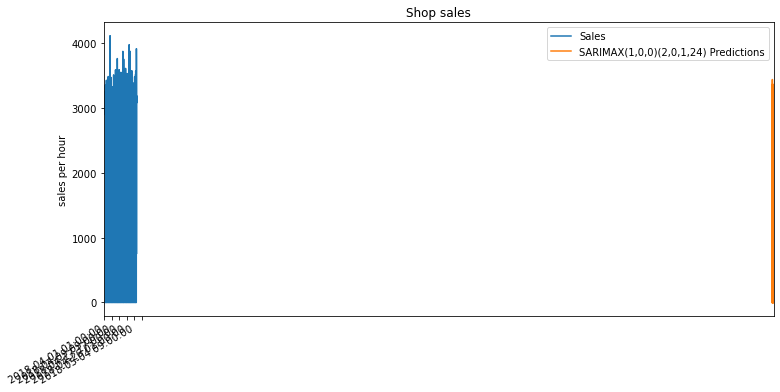

In [11]:
# Plot predictions against known values
title='Shop sales'
ylabel='sales per hour'
xlabel=''

ax = test['Sales'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('Holidays==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

## Validating model

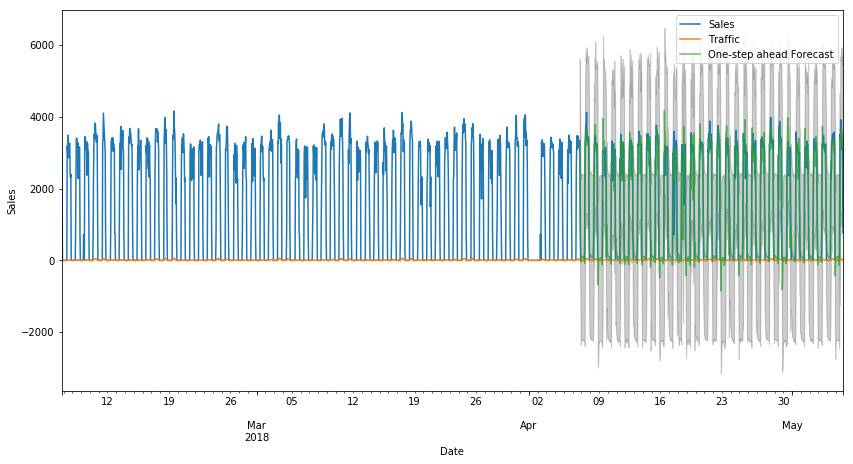

In [42]:
##Forecast the model by predicting the final month of the time series for which there is data:

prediction = results.get_prediction(start=pd.to_datetime('2018-04-06 19:00:00'), dynamic=False)
pred_ci = prediction.conf_int()

ax = cut_df['2018-02-06 19:00:00':].plot(label='observed')
prediction.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

##OK this is a really poor model!

In [44]:
##Integrating the traffic information
#Check causality between traffic and sales - this should be a given! 
#The order matters. The time averging into hours may make traffic-sales appear contemporaneous.

print(sm.tsa.stattools.grangercausalitytests(cut_df[['Traffic', 'Sales']],1))
print('\n\n',sm.tsa.stattools.grangercausalitytests(cut_df[['Sales','Traffic']],1))


'''
Suggests time averging can't distinguish causality since we can reject the null for both cases..
'''


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=73.0313 , p=0.0000  , df_denom=13239, df_num=1
ssr based chi2 test:   chi2=73.0479 , p=0.0000  , df=1
likelihood ratio test: chi2=72.8471 , p=0.0000  , df=1
parameter F test:         F=73.0313 , p=0.0000  , df_denom=13239, df_num=1
{1: ({'ssr_ftest': (73.03131561870477, 1.4146499509048993e-17, 13239.0, 1), 'ssr_chi2test': (73.04786474982163, 1.2654342941935038e-17, 1), 'lrtest': (72.84712287476577, 1.400916801219889e-17, 1), 'params_ftest': (73.03131561869955, 1.4146499509080353e-17, 13239.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x00000207032B0438>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x00000207032B0550>, array([[0., 1., 0.]])])}

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=196.3332, p=0.0000  , df_denom=13239, df_num=1
ssr based chi2 test:   chi2=196.3777, p=0.0000  , df=1
likelihood ratio test: chi2=194.9

In [45]:
'''
Put both traffic and sales into the same model. Need to introduce a lag component as an exogenous variable.
'''

cut_df['diffT'] = cut_df['Sales']
cut_df['lag'] = cut_df['diffT'].shift()
cut_df.dropna(inplace=True)

model = sm.tsa.SARIMAX(endog=cut_df['Sales'], exog=cut_df[['lag']],order=(2, 1, 2), seasonal_order=(1, 1, 0,12), 
                                enforce_stationarity=False, enforce_invertibility=False)

results = model.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                13242
Model:             SARIMAX(2, 1, 2)x(1, 1, 0, 12)   Log Likelihood             -107555.267
Date:                            Tue, 16 Apr 2019   AIC                         215124.535
Time:                                    10:21:52   BIC                         215176.958
Sample:                                11-01-2016   HQIC                        215142.037
                                     - 05-06-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
lag           -0.1260      6.739     -0.019      0.985     -13.333      13.081
ar.L1          0.5507      9.063   

In [49]:
'''
Forecasting one month ahead:
The model is really poor so this will produce a meaningless result
'''

#forecast, std,conf = results.forecast(steps=744, exog=cut_df[['lag']) #Approx hours in the next month. Needs an exog elemnt of len=744
#plt.plot(forecast)

'\nForecasting one month ahead:\nThe model is really poor so this will produce a meaningless result\n'

References:

https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

https://barnesanalytics.com/analyzing-multivariate-time-series-using-arimax-in-python-with-statsmodels
    